# Speech Super-Resolution and Enhancement with Flow-Matching

In this best practice, we will walk through a complete **best-practice pipeline for training and inference** a **Flow Matching-based Speech Super-Resolution and Enhancement model**. Specifically, you will learn:

- How to prepare clean and degraded speech data
- How to build training pairs by downsampling, adding noise and rir
- How to train a flow-matching model for enhancement and super-resolution
- How to perform inference using the trained model

Let’s get started!

## Related Model: FlowHigh

This best practice is based on **FlowHigh**, a recently proposed generative model designed for **audio super-resolution** using **flow matching**. 

FlowHigh addresses the limitations of traditional diffusion models, which often require a large number of sampling steps to generate high-quality audio. Instead, FlowHigh leverages **Conditional Flow Matching (CFM)** to learn a continuous transformation from low-resolution (LR) audio to high-resolution (HR) audio representations — efficiently generating high-fidelity outputs with just **a single ODE step**.

Originally, FlowHigh was designed **specifically for super-resolution tasks**, i.e., reconstructing missing high-frequency components in low-bandwidth speech signals (e.g., from 8 kHz to 48 kHz). It does not directly support **speech enhancement** (e.g., denoising). In this tutorial, we will **modify and extend the FlowHigh** to support both Speech Super-Resolution and Speech Enhancement.

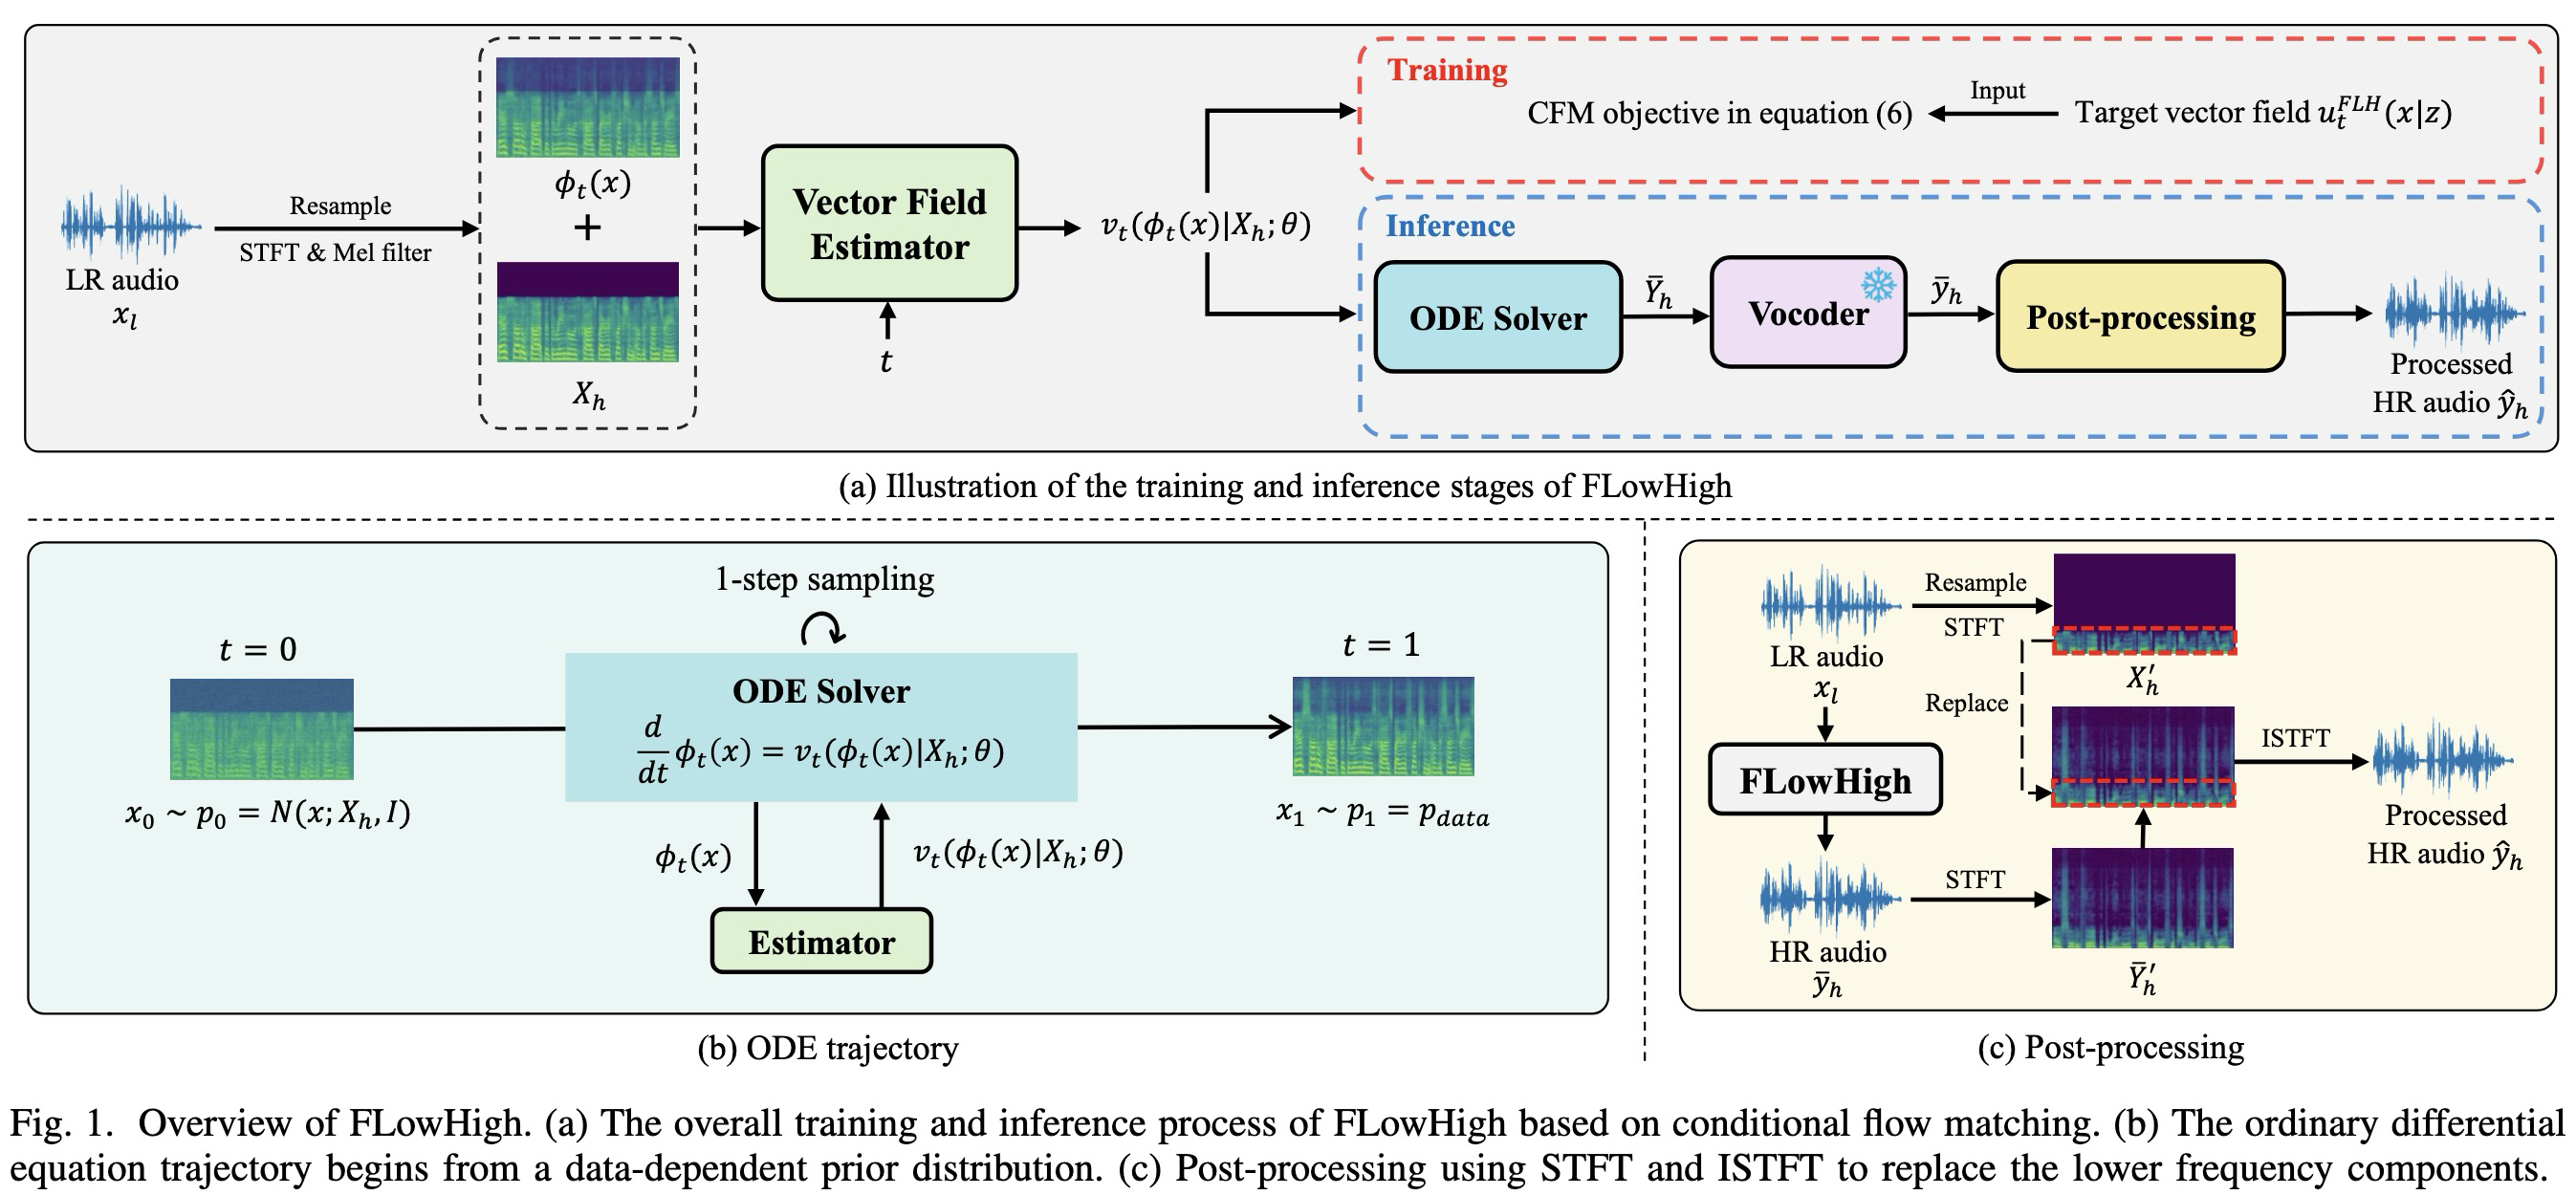

## Data Preparation

We will construct our dataset by combining **clean speech** from the [LibriTTS-R](https://www.openslr.org/141/) corpus and **noise/reverberation** data from the [DNS-Challenge](https://github.com/microsoft/DNS-Challenge) dataset.

To simplify the demonstration and speed up training, we will only use `train-clean-100` subset from **LibriTTS-R**.

We'll simulate degraded speech signals by mixing clean speech with additive noise and optional reverberation.

To simplify the setup process, we provide a shell script that automatically downloads and extracts all necessary data. The script will organize the files under the `data/` directory.

### Run the following command to download the data:

In [ ]:
# Download and extract the datasets.
!bash download_datasets.sh

# To download all the data for formal training, add the --all flag.
# !bash download_datasets.sh --all

The **LibriTTS-R** dataset provides clean speech recordings at a sampling rate of **24 kHz**. However, the **DNS-Challenge** noise and RIR files come in 48 kHz. To ensure consistency, we need to **resample all noise and RIR waveforms to 24 kHz**.

### Run the following command to resample the DNS-Challenge data:


In [ ]:
# Resample DNS-Challenge Noise to 24kHz
!bash resample_wavs.sh data/dns_challenge/noise/ data/dns_challenge/noise_24k/ 24000
# Resample DNS-Challenge RIR to 24kHz
!bash resample_wavs.sh data/dns_challenge/rir/ data/dns_challenge/rir_24k/ 24000

## Understanding the Original DataLoader in FlowHigh

Before we introduce our modifications for **speech enhancement**, let's first understand how the original FlowHigh model prepares data for **speech super-resolution**.

### Super-Resolution Strategy

In FlowHigh, the training data consists of pairs of:
- A **degraded waveform**: low-resolution input (with missing high-frequency components)
- A **clean high-resolution waveform**: the ground-truth target

To simulate realistic low-resolution input, FlowHigh uses a downsampling and upsampling strategy:

1. **Start with a high-resolution waveform** (e.g., 24 kHz from LibriTTS-R)
2. **Apply a random low-pass filter** (e.g., Chebyshev filter)
3. **Downsample** the filtered waveform to a random lower sampling rate (e.g., 8–22 kHz)
4. **Upsample** the result back to the original sampling rate (e.g., 24 kHz)
5. The resulting audio **lacks high-frequency components** — effectively simulating low-quality audio

The model is then trained to recover the missing high-frequency information.

---

### Code Snapshot: Super-Resolution Data Preparation

Here is a simplified view of the core data generation logic used in FlowHigh:

```python
# Normalize input
src_wave /= np.max(np.abs(src_wave))

# Randomly choose a lower sample rate
sampling_rates = list(range(self.min_value, self.max_value + step, step))
random_sr = random.choice(sampling_rates)

if random_sr != tgt_sr:
    # Apply low-pass filter
    hi = (random_sr // 2) / (src_sr // 2)
    sos = cheby1(order, ripple, hi, btype='lowpass', output='sos')
    filtered = sosfiltfilt(sos, src_wave)

    # Downsample → Upsample
    down_cond = resample_poly(filtered, random_sr, src_sr)
    up_cond = resample_poly(down_cond, tgt_sr, random_sr)
else:
    up_cond = src_wave

# Align length and convert to tensor
```

This up_cond is used as the input to the model, and the original high-resolution src_wave is used as the target output.


## Extending DataLoader for Speech Enhancement

The original FlowHigh model only supports **speech super-resolution**, where low-resolution audio is created by downsampling and then upsampling high-resolution audio. To extend its capability to **speech enhancement**, we modify the data pipeline to simulate noisy and reverberant environments.

In real-world audio, degradation is not just caused by low sampling rates. We often encounter:

- **Background noise** (e.g., street noise, keyboard typing, fan sounds)
- **Room reverberation** (e.g., echo or reflection from walls and ceilings)

To help the model generalize to these conditions, we **randomly add noise and/or RIR** during training, while keeping the clean, high-quality waveform as the ground-truth target.

However, we **do not always apply noise or RIR** — they are added with some **probability**, so that the model can also handle clean inputs without overfitting to noisy conditions.

With this modification, FlowHigh supports the following modes during training:

| Mode | Description | Task |
|------|-------------|------|
| **Mode 1: Downsample + Noise + RIR** | Apply all distortions (bandwidth, noise, reverb) | **Joint Super-Resolution + Enhancement** |
| **Mode 2: Noise + RIR only** | Keep full bandwidth, apply only noise/reverb | **Speech Enhancement only** |
| **Mode 3: Downsample only** | Remove high frequencies without adding noise | **Super-Resolution only** |

To simulate noisy conditions, we mix clean speech with a randomly selected noise clip at a randomly chosen **Signal-to-Noise Ratio (SNR)**:

```python
def add_noise(self, x, noise, snr_db_range=(0, 20)):
    # Match length
    ...
    snr_db = random.randint(*snr_db_range)
    snr_linear = 10 ** (-snr_db / 20)
    scale = self.rms(x) / self.rms(noise) * snr_linear
    noisy = x + scale * noise
    ...
    return normalized_noisy
```
This ensures that the added noise is proportional and controlled, allowing the model to learn how to denoise at different noise levels, from slight background hum to heavy interference.

To simulate room reverberation, we convolve clean speech with a randomly selected Room Impulse Response (RIR) using FFT-based convolution:

```python
def add_rir(self, clean_wav, rir_wav):
    rir_wav = rir_wav / np.max(np.abs(rir_wav))
    reverberant = fftconvolve(clean_wav, rir_wav, mode="full")[:len(clean_wav)]
    return normalize(reverberant)
```
This helps the model learn to suppress echoes and reflections, which is an essential skill for robust speech enhancement.


## Preparing the Configuration File

We provide a pre-defined configuration file located at: ```configs/config_libritts_r_noise_0.9_rir_0.5.json```

This configuration is designed for **joint speech enhancement and super-resolution** using LibriTTS-R and DNS-Challenge datasets. Below, we explain the key parameters included in this config.


### Data Settings

- **`data_path`**:  
  Path to the clean, high-resolution audio data (24kHz).  
  Set to: ```data/libritts_r/LibriTTS_R/train-clean-100/```

- **`noise_path`**:  
Directory containing 24kHz noise samples from the DNS-Challenge dataset.  
Set to: ```data/dns_challenge/noise_24k/```


- **`rir_path`**:  
Directory containing 24kHz Room Impulse Responses (RIRs).  
Set to: ```data/dns_challenge/rir_24k/```


- **`noise_prob`**:  
Probability of adding noise to an input sample during training.  
Set to `0.9`, meaning 90% of training samples will have noise added.

- **`rir_prob`**:  
Probability of applying reverberation using an RIR.  
Set to `0.5`, meaning half the samples will include room acoustics simulation.

- **`downsample_min` and `downsample_max`**:  
Define the lower and upper bounds (in Hz) for randomly downsampling the clean audio before upsampling back to 24kHz.  
This simulates bandwidth-limited input.  
Set to: ```downsample_min = 4000``` and ```downsample_max = 24000```

> To disable enhancement (and only train for super-resolution), you can:
> - Leave `noise_path` and `rir_path` empty, or
> - Set `noise_prob` and `rir_prob` to `0`

> To disable super-resolution (and only train for enhancement), you can:
> - Set both `downsample_min` and `downsample_max` to the original sample rate of the source audio.

### Vocoder Settings

We uses a pretrained **BigVGAN** vocoder from the official BigVGAN repo to reconstruct waveforms from mel-spectrograms.

- **`vocoderpath`**:  
Path to the BigVGAN generator checkpoint: `vocoder/BIGVGAN/checkpoint/bigvgan_generator.pt`


- **`vocoderconfigpath`**:  
Configuration file for the BigVGAN vocoder: `vocoder/BIGVGAN/config/bigvgan_base_24khz_100band.json`


### Training Settings

Other relevant parameters in the config include:

- `batchsize`: 64
- `lr`: 3e-4
- `n_train_steps`: 1,000,001
- `save_model_every`: 10,000
- `save_dir`: Directory to save logs and checkpoints: `./logs_libritts_r_noise_0.9_rir_0.5`

## Model Training

Once the configuration file is ready, training the model is as simple as running the following command:

```bash
python train.py --config=./configs/config_libritts_r_noise_0.9_rir_0.5.json
```

This will start training the FlowHigh model using the joint speech enhancement + super-resolution setup described in the config.

### Logs and Checkpoints
- All logs and model checkpoints will be saved to the directory: ```./logs_libritts_r_noise_0.9_rir_0.5/```
- Training progress (loss, evaluation metrics, etc.) is logged in tfevents format. You can monitor training with TensorBoard: ```tensorboard --logdir=./logs_libritts_r_noise_0.9_rir_0.5```
- Model checkpoints will be saved periodically based on the save_model_every setting in the config.

Training time depends on your hardware and training steps. You can reduce n_train_steps in the config for quick experimentation.

Once training is complete, you will have a model capable of restoring clean, high-resolution speech from noisy or bandwidth-limited inputs.

## Inference

Once the model has been trained, we can run inference on unseen audio samples to perform **speech enhancement** and/or **super-resolution**.

We provide a convenient script named `inference.sh` that wraps the full inference command using the correct parameters.

### Run Inference

To run inference, place the .wav files you want to process into the `./in_wavs/` directory and simply execute the following shell command:


In [ ]:
!bash inference.sh

After running inference, the restored audio files will be saved in the `./out_wavs/` directory.

You can listen to them or compare them against the original degraded inputs.